In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\MSC BDA\Aman Sir\smart_ambulance_synthetic_data.csv")

In [9]:
df.head()

,timestamp,patient_id,heart_rate,spo2,sbp,dbp,vibration,patient_type,route
0,2026-02-14 10:53:23.388678,1,99.3,95.59,130.7,78.3,0.496,stable,highway
1,2026-02-14 10:53:24.388678,1,97.5,95.23,130.2,78.4,0.532,stable,highway
2,2026-02-14 10:53:25.388678,1,96.6,95.16,129.7,78.3,0.300,stable,highway
3,2026-02-14 10:53:26.388678,1,98.1,95.22,130.3,78.3,0.435,stable,highway
4,2026-02-14 10:53:27.388678,1,97.3,95.43,130.1,78.3,0.475,stable,highway


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50940 entries, 0 to 50939
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     50940 non-null  datetime64[ns]
 1   patient_id    50940 non-null  int64         
 2   heart_rate    50940 non-null  float64       
 3   spo2          50940 non-null  float64       
 4   sbp           50940 non-null  float64       
 5   dbp           50940 non-null  float64       
 6   vibration     50940 non-null  float64       
 7   patient_type  50940 non-null  object        
 8   route         50940 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 3.5+ MB


In [6]:
df.isnull().sum()

timestamp       0
patient_id      0
heart_rate      0
spo2            0
sbp             0
dbp             0
vibration       0
patient_type    0
route           0
dtype: int64

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

In [11]:
# 1. Define Vibration Threshold (95th percentile)
vibration_threshold = df['vibration'].quantile(0.95)

# 2. Calculate gradients to find sudden changes
df['spo2_change'] = df['spo2'].diff()
df['hr_change'] = df['heart_rate'].diff()

# 3. Create Artifact Masks
# SpO2 Drop: High vibration + drop > 2%
spo2_mask = (df['vibration'] > vibration_threshold) & (df['spo2_change'] < -2.0)
# HR Spike: High vibration + spike > 5 bpm
hr_mask = (df['vibration'] > vibration_threshold) & (df['hr_change'] > 5.0)

# 4. Backup original values for comparison plotting later
df['spo2_original'] = df['spo2'].copy()
df['hr_original'] = df['heart_rate'].copy()

# 5. Correct Artifacts: Set identified spikes/drops to NaN and interpolate
df.loc[spo2_mask, 'spo2'] = np.nan
df.loc[hr_mask, 'heart_rate'] = np.nan

df['spo2'] = df['spo2'].interpolate(method='linear')
df['heart_rate'] = df['heart_rate'].interpolate(method='linear')

print(f"Corrected {spo2_mask.sum()} SpO2 artifacts and {hr_mask.sum()} HR artifacts.")

Corrected 53 SpO2 artifacts and 23 HR artifacts.


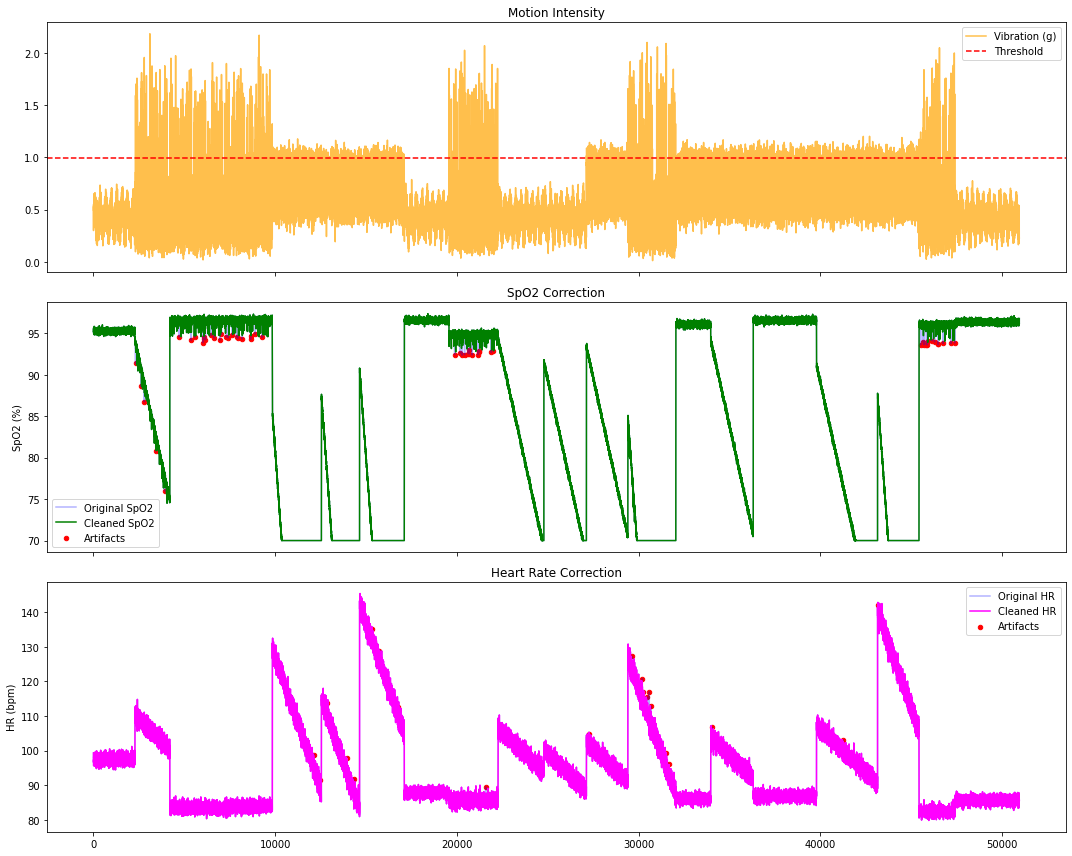

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
x = df.index

# Vibration Plot
axes[0].plot(x, df['vibration'], label='Vibration (g)', color='orange', alpha=0.7)
axes[0].axhline(vibration_threshold, color='red', linestyle='--', label='Threshold')
axes[0].set_title('Motion Intensity')
axes[0].legend()

# SpO2 Comparison
axes[1].plot(x, df['spo2_original'], label='Original SpO2', color='blue', alpha=0.3)
axes[1].plot(x, df['spo2'], label='Cleaned SpO2', color='green', linewidth=1.5)
axes[1].scatter(x[spo2_mask], df.loc[spo2_mask, 'spo2_original'], color='red', s=20, label='Artifacts')
axes[1].set_ylabel('SpO2 (%)')
axes[1].set_title('SpO2 Correction')
axes[1].legend()

# Heart Rate Comparison
axes[2].plot(x, df['hr_original'], label='Original HR', color='blue', alpha=0.3)
axes[2].plot(x, df['heart_rate'], label='Cleaned HR', color='magenta', linewidth=1.5)
axes[2].scatter(x[hr_mask], df.loc[hr_mask, 'hr_original'], color='red', s=20, label='Artifacts')
axes[2].set_ylabel('HR (bpm)')
axes[2].set_title('Heart Rate Correction')
axes[2].legend()

plt.tight_layout()
plt.show()

The impact of motion on physiological signals and the effectiveness of artifact correction. Periods where vibration exceeds the threshold correspond to sudden drops in SpO₂ and sharp spikes or fluctuations in heart rate, indicating motion-induced artifacts rather than true physiological changes. The cleaning algorithm successfully detects and corrects these corrupted segments, restoring stable and clinically plausible SpO₂ (94–97%) and heart rate trends, thereby improving signal reliability.